In [1]:
import os
import sys
import subprocess
import shutil

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))
import Hyperbolic as hyp

# AP code

In [2]:
def find_component(node, connected_components):
    for i, component in enumerate(connected_components):
        if node in component:
            return i
    raise ValueError(f'Component for node {node} not found')

In [3]:
def cascade_remove_links(G):

    keep_going = True
    while keep_going:
        keep_going = False

        clusters_in_layers = [list(nx.connected_components(g)) for g in G]

        for i, g in enumerate(G):
            clusters_to_search = clusters_in_layers[:i] + clusters_in_layers[i + 1:]
            for edge in g.edges():
                if any(find_component(edge[0], clusters) != find_component(edge[1], clusters)
                       for clusters in clusters_to_search):
                    keep_going = True
                    g.remove_edge(*edge)
    
    return G

In [4]:
def articulation_points_multiplex(G):
    ap = set(nx.articulation_points(G[0]))
    return ap.union(*[nx.articulation_points(g) for g in G[1:]])

In [5]:
def max_comp(g):
    return max(nx.connected_components(g), key=len)

In [6]:
def remove_ap(G):
    G = cascade_remove_links(G)

    gcc = max_comp(G[0])
    gcc_size = len(gcc)

    for g in G:
        g.remove_nodes_from([n for n in g if n not in gcc])

    art_points = articulation_points_multiplex(G)

    for g in G:
        g.remove_nodes_from(art_points)

    return G, art_points, gcc_size

# Experiment

In [7]:
kbar = 4.
gamma = 3.
T = .4
N = 5000

In [8]:
def generate(N, kbar, gamma, T):
    seed = 42
    np.random.seed(seed)

    kmin = hyp.CalculateKmin(kbar, gamma)
    print('kmin: ', kmin)

    C = hyp.CalculateC(kbar, T, gamma)
    print('C: ', C)

    R = hyp.CalculateR(N, C)
    print('R: ', R)

    kappa = hyp.SampleKappa(N, kmin, gamma)
    theta = hyp.SampleTheta(N)

    r = hyp.ChangeVariablesFromS1ToH2(N, kappa[:], R, kmin)

    hyp.PrintCoordinates(r[:], theta[:], kappa[:], 'coords.txt')

    subprocess.call(['hyperb.exe', 'coords.txt', str(seed), str(N), str(kbar), str(T)])
    links = hyp.ReadLinks('links.coords.txt')
    return nx.Graph(links), np.array(r), np.array(theta)

In [9]:
def generate_real(path):
    datapath = '../../real_data_experiments/multiplex_embeddings_data'
    datapath = os.path.join(datapath, path)
    shutil.copyfile(datapath, 'network.txt')
    subprocess.call(['HyperMapWin.exe'])
    coords = np.array(hyp.ReadCoordinates('coordinates_embedding.txt'))
    return nx.read_edgelist(datapath), coords[:, 2], coords[:, 1]

In [10]:
def ksi_in_ap_removal(N, kbar, gamma, T):
    G, _, theta = generate(N, kbar, gamma, T)

    ksi = []
    while True:
        gcc = max_comp(G)
        G.remove_nodes_from([n for n in G if n not in gcc])
        ksi.append(abs(np.exp(1j * theta[list(gcc)]).sum() / len(gcc)))
        art_points = list(nx.articulation_points(G))
        G.remove_nodes_from(art_points)
        if not art_points:
            break
    return ksi

In [11]:
plt.rc('text', usetex=True)
plt.rc('font', size=30, **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['savefig.bbox'] = 'tight'
%matplotlib inline

In [186]:
ksi_curves = []
for kbar in [.1, 2, 4, 6, 8, 10]:
    ksi_curves.append(ksi_in_ap_removal(N, kbar, gamma, T))

kmin:  0.05
C:  0.029720516134223548
R:  24.066221768275167
number of links:	 232
kmin:  1.0
C:  0.5944103226844709
R:  18.074757221167182
number of links:	 4718
kmin:  2.0
C:  1.1888206453689418
R:  16.68846286004729
number of links:	 9533
kmin:  3.0
C:  1.7832309680534126
R:  15.877532643830964
number of links:	 14391
kmin:  4.0
C:  2.3776412907378837
R:  15.302168498927402
number of links:	 19226
kmin:  5.0
C:  2.9720516134223542
R:  14.855881396298983
number of links:	 23967


In [197]:
generate_real('arXiv/l_4.txt')

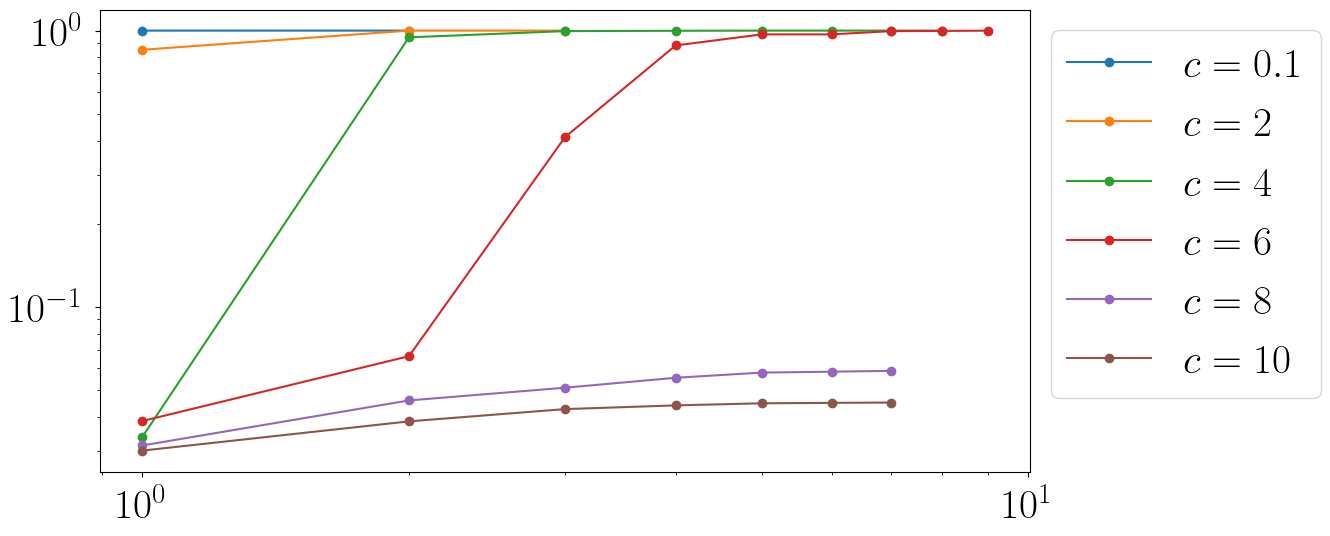

In [187]:
plt.figure(figsize=(12, 6))
for kbar, ksi in zip([.1, 2, 4, 6, 8, 10], ksi_curves):
    plt.loglog(range(1, len(ksi) + 1), ksi, 'o-', label=fr'$c = {kbar}$')
plt.legend(bbox_to_anchor=(1, 1));